In [28]:
import numpy as np
import pims
from pims.bioformats import BioformatsReader
import skimage as ski
import skimage.transform as skitransform
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn import linear_model
import sklearn
import register_stack_correlation_lib as reglib
%autoreload 2


In [ ]:
class IndexMaker:
    def __init__(self,reader):
        self.sizes = reader.sizes
    def to_index(self,t,z):
        return self.sizes['z'] * t + z

In [2]:
image_source = ('/Users/andrewkennard/Desktop/'
                '20180502_63x_2xopt_Wounding_2_Subimage_downsampled.tif')
images = BioformatsReader(image_source)
images.bundle_axes = 'zyx'
images.iter_axes = 't'

/Users/andrewkennard/.virtualenvs/myenv/lib/python3.6/site-packages/pims/bioformats.py:386: UserWarning: Due to an issue with JPype 0.6.0, reading is slower. Please consider upgrading JPype to 0.6.1 or later.
  warn('Due to an issue with JPype 0.6.0, reading is slower. '


In [ ]:
t = 5
z = 40
k = images.sizes['z'] * t + z
K = IndexMaker(images)
plt.imshow(images[K.to_index(t,z)])

In [27]:
downscale_factor = 4
im0 = images[10]
im1 = images[11]
im0_downscaled = reglib.downscale_frame(im0,downscale_factor)
im1_downscaled = reglib.downscale_frame(im1,downscale_factor)

0.5596067589940503


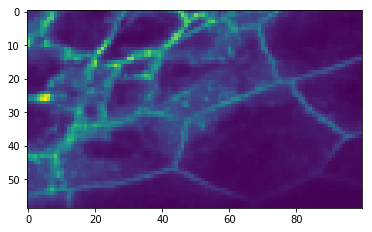

In [11]:
# Downsample image. Determine the appropriate image size based on the downsample factor. Downsample each image
# in a z-stack--no good way to vectorize
downscale_factor = 4
t0 = time.perf_counter()
test_downscale = skitransform.pyramid_reduce(im0[0,...],
                     downscale=downscale_factor)
downscale_shape = (im0.shape[0],) + test_downscale.shape
im0_downscale = np.zeros(downscale_shape)
im1_downscale = np.zeros(downscale_shape)
for i in range(im0x.shape[0]):
    im0_downscale[i,...] = skitransform.pyramid_reduce(im0[i,...],
                               downscale=downscale_factor)
    im1_downscale[i,...] = skitransform.pyramid_reduce(im1[i,...],
                               downscale=downscale_factor)
t1 = time.perf_counter()
plt.imshow(im0_downscale[35,...])
print(t1-t0)

(3, 236, 400)
28.020370575910604
82372181.0


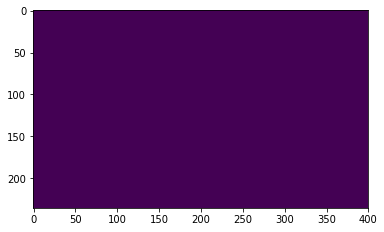

In [20]:
xx = im_0[:3,...]
f0 = np.fft.fft2(xx)
print(f0.shape)
print(np.min(abs(f0)))
print(np.max(abs(f0)))
plt.imshow(abs(f0[0,...]))

In [ ]:
max_correlation = np.zeros((im_0.shape[0],im_1.shape[0]))
max_correlationx = np.zeros((im0x.shape[0],im1x.shape[0]))
mean0 = np.zeros((im_0.shape[0],1,1))
mean1 = np.zeros((im_1.shape[0],1,1))
mean0x = np.zeros((im_0.shape[0],1,1))
mean1x = np.zeros((im_1.shape[0],1,1))
for i in range(im_0.shape[0]):
    mean0[i] = np.mean(im_0[i,...])
    mean1[i] = np.mean(im_1[i,...])
    mean0x[i] = np.mean(im0x[i,...])
    mean1x[i] = np.mean(im1x[i,...])
f0 = np.fft.fft2(im_0[...]/mean0)
f1 = np.fft.fft2(im_1[...]/mean1)
f0x = np.fft.fft2(im0x[...]/mean0x)
f1x = np.fft.fft2(im1x[...]/mean1x)
print(f0.shape)

In [ ]:
t0=time.perf_counter()
for i in range(im_1.shape[0]):
        im_product = f0 * f1[i,...].conj()
        cc_image = np.fft.ifft2(im_product)
        #print(cc_image.shape)
        ccx = cc_image.reshape(cc_image.shape[0],-1)
        #ccx = im_product.reshape(im_product.shape[0],-1)
        #print(ccx.shape)
        max_correlation[:,i] = np.max(ccx.real,axis=1)
t1 = time.perf_counter()
print(t1-t0)

In [ ]:
max_correlationx = np.zeros((im0x.shape[0],im1x.shape[0]))
t0 = time.perf_counter()
for i in range(im1x.shape[0]):
    im_product = (f0x * f1x[i,...].conj())/np.abs(f0x * f1x[i,...].conj())
    cc_image = np.fft.ifft2(im_product)
    ccx = cc_image.reshape(cc_image.shape[0],-1)
    max_correlationx[:,i] = np.max(ccx.real,axis=1)
t1 = time.perf_counter()
print(t1-t0)
fig,ax = plt.subplots(figsize=(10,20),ncols=2)
ax[0].imshow(max_correlation)
ax[1].imshow(max_correlationx)
print(np.max(max_correlationx))

In [ ]:
# Implement a really stupid linear regression class where the slope is assumed 
# to be 1 i.e. just fit the intercept. The least-squares intercept is simply 
# the difference between the mean of X and the mean of y.
# In order to use RANSAC to estimate, need to provide a fit(X,y) method and a 
# score(X,y) method. fit method will just return mean(y) - mean(x). 
# score method will return the R^2 coefficient of determination
class DumbInterceptEstimator:
    def fit(self,X,y):
        self.intercept_ = np.mean(y) - np.mean(X)
        return self
    
    
    def predict(self,X):
        return X + self.intercept_
    
    
    def score(self,X,y):
        y_pred = self.predict(X)
        ss_res = ((y - y_pred)**2).sum()
        ss_tot = ((y - np.mean(y))**2).sum()
        return 1 - (ss_res / ss_tot)
    
    
    def get_params(self,deep=True):
        out = dict()
        return out
    
    
    def set_params(self,**params):
        raise ValueError

In [ ]:
from skimage.filters import (threshold_li,threshold_otsu)
X = np.arange(max_correlationx.shape[0])
y = np.argmax(max_correlationx,axis=0)
w = np.max(max_correlationx,axis=0)
li_threshold = threshold_otsu(max_correlationx)
X = X[np.max(max_correlationx,axis=0)>=li_threshold]
y = y[np.max(max_correlationx,axis=0)>=li_threshold]
w = w[w>li_threshold]
X = X.reshape(-1,1)
y = y.reshape(-1,1)
print(y.shape)
plt.imshow(max_correlationx)
plt.scatter(X,y,c='r')
ransac = linear_model.RANSACRegressor(base_estimator=DumbInterceptEstimator(),residual_threshold=1.5)
ransac.fit(X,y)
plt.plot(X,ransac.predict(X),c='b')
a = ransac.get_params()
print(ransac.estimator_.intercept_)
print(y.mean() - X.mean())
print(max(w))
print(ransac.residual_threshold)
print(np.median(np.abs(y-np.median(y))))
print(sum(ransac.inlier_mask_)/len(ransac.inlier_mask_))

In [ ]:
plt.plot(max_correlationx[72,:])
print(np.array([np.arange(73),np.argmax(max_correlationx,axis=1)]))

In [ ]:
fig,ax = plt.subplots(figsize=(10,20),ncols=3)
ax[0].imshow(im_0[72,...])
ax[1].imshow(im_1[52,...])
ax[2].imshow(im_1[46,...])

In [ ]:
from skimage.filters import try_all_threshold

img = max_correlationx / np.max(max_correlationx)

fig,ax = try_all_threshold(img,figsize=(10,8),verbose=False)
plt.show()

In [ ]:
im0x = ski.transform.resize(im_0,(73,118,200),anti_aliasing=True)
print(im0x.shape)
print(im_0.shape)
fig,ax = plt.subplots(figsize=(10,20),nrows=1,ncols=2)
ax[0].imshow(ski.transform.pyramid_reduce(im0x[35,...],downscale=4))
ax[1].imshow(im_0[35,...])
plt.show()

In [ ]:
ski.__version__

In [ ]:
min_difference = np.zeros((im_0.shape[0],im_1.shape[0]))
for i in range(im_0.shape[0]):
    x = np.abs(im_0 - im_1[i,...])
    xx = x.reshape(x.shape[0],-1)
    min_difference[i,:] = np.sum(xx,axis=1)
plt.imshow(min_difference)

In [ ]:
?plt.subplots

In [ ]:
from skimage.transform import (hough_line,hough_line_peaks)
h,theta,d = hough_line(max_correlation)
hough_line_peaks(h,theta,d)

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(max_correlation)
for _, angle, dist in zip(*hough_line_peaks(h,theta,d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - 73 * np.cos(angle)) / np.sin(angle)
    ax.plot((0,73),(y0,y1),'-r')
ax.set_xlim((0,73))
ax.set_ylim((73,0))